In [ ]:
!pip install --target=$nb_path unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
import unidecode as unidecode
import os
import torch
import csv
import numpy as np
import pandas as pd
import re
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
maxlen1,maxlen2=10,10

In [ ]:
import re
from unidecode import unidecode

def sentence2wordlist(sentence, putEOS=1):
    words = unidecode(sentence).lower().strip()
    words = re.sub(r"([,.!?0-9])", r" \1 ", words)
    words = re.sub(r"[^a-zA-Z,.!?0-9]+", r" ", words)
    ret = words.split()
    if putEOS:
        ret.append('<EOS>')
    return ret

print(sentence2wordlist("[ab c'dêFg hIj.7k+ -*n/", putEOS=1))


['ab', 'c', 'defg', 'hij', '.', '7', 'k', 'n', '<EOS>']


In [ ]:
def createfile(maxlen1=maxlen1,maxlen2=maxlen2,masterpath='/content/drive/MyDrive/NLP/SEQ/',
               srcfile='eng-fra.txt',\
               datafiles=('eng-fra_train.txt' , 'eng-fra_test.txt'),vocal_files=('engLookup.csv' , 'fraLookup.csv'),
               ratio=(9,1) , maxlines=int(1e6)):

               linecount=0;
               traincount=0;
               testcount=0;
               pool=ratio[0]+ratio[1]
               tests=[]
               wordbank1=['<PAD>' , '<SOS>' , '<EOS>']
               wordbank2=['<PAD>' , '<SOS>' , '<EOS>']
               with open(masterpath+datafiles[0] , 'w') as f1:
                with open((masterpath+srcfile) , encoding='utf-8') as f:
                  for line in f:
                    randvar=torch.randint(pool,(1,))
                    if(randvar<ratio[0]):
                      s1,s2=line.split('\t')
                      word1=sentence2wordlist(s1)
                      word2=sentence2wordlist(s2)
                      if(len(word1)<maxlen1 and len(word2)<maxlen2):
                        f1.write(line)
                        for word in word1:
                          if not word in wordbank1: wordbank1.append(word)
                        for word in word2:
                          if not word in wordbank2: wordbank2.append(word)
                        traincount+=1
                    elif (randvar>=ratio[0] and randvar<ratio[0]+ratio[1]):
                      tests.append(line)
                    if linecount>maxlines:
                      break
                    linecount+=1
               with open(masterpath+datafiles[1] , 'w') as f2:
                for line in tests:
                  s1,s2=line.split('\t')
                  word1=sentence2wordlist(s1)
                  word2=sentence2wordlist(s2)
                  if(len(word1)<maxlen1 and len(word2)<maxlen2):
                    invocab=1
                    for word in word1:
                      if not word in wordbank1:
                        invocab=0
                        break
                    for word in word2:
                      if not word in wordbank2:
                        invocab=0
                        break
                    if invocab:
                      f2.write(line)
                      testcount+=1
               for savecount,wordbank in enumerate((wordbank1,wordbank2)):
                mydict=dict(zip(list(range(0,len(wordbank))) , wordbank))
                with open(masterpath+vocal_files[savecount] , "w" , newline="") as fp:
                  writer = csv.DictWriter(fp,fieldnames=mydict.keys())
                  writer.writeheader()
                  writer.writerow(mydict)
               return linecount, (traincount,testcount)


createfile(ratio=(98,2))


# /content/drive/MyDrive/NLP/SEQ/engLookup.csv


(135842, (75392, 1419))

In [ ]:
def look2Lookups(path):
  with open(path, 'r') as data:
    int2word=list(csv.DictReader(data))[0]
    int2word={int(k): v for k,v in int2word.items()}
    word2int={v: k for k,v in int2word.items()}
    return int2word,word2int

def load4lookup(folder='/content/drive/MyDrive/NLP/SEQ/' , names=("engLookup.csv" , "fraLookup.csv")):
  return look2Lookups(folder+names[0]) , look2Lookups(folder+names[1])

def word2int(word,lang):
  return [Lookdown[lang][key] for key in word]

def int2word(ints,lang):
  return [Lookups[lang][key] for key in ints]


(int2lang1,lang12int),(int2lang2,lang22int)=load4lookup()

Lookups={'eng':int2lang1 , 'fra' : int2lang2}
Lookdown={'eng' : lang12int , 'fra' : lang22int}

numwords1=len(Lookups['eng'].items())
numwords2=len(Lookups['fra'].items())

In [ ]:
len(Lookups['eng'].items())

8909

In [ ]:
class LangDataset:
  def __init__(self,langname,excdim0s,dim1):
    self.langname=langname
    self.data={'train': torch.zeros((excdim0s[0] , dim1), dtype=torch.int32, device=device),\
               'valid': torch.zeros((excdim0s[1] , dim1), dtype=torch.int32, device= device),\
                'test': torch.zeros((excdim0s[2], dim1) , dtype=torch.int32, device= device)}

  def addSequence(self,words,whichset,idx0):
      mytensor=torch.IntTensor(word2int(words,lang=self.langname)).to(device).unsqueeze(0)
      self.data[whichset][idx0,0:mytensor.shape[1]]=mytensor

  def trim0(self,traincount,validcount,testcount):
    self.data['train']=self.data['train'][0:traincount]
    self.data['valid']=self.data['valid'][0:validcount]
    self.data['test']=self.data['test'][0:testcount]


  def rearrange(self,whichset,indices):
    self.data[whichset]=self.data[whichset][indices,:]

  def __getitem__(self,params):
     key, idx=params
     return self.data[key][idx]
  def len(self,whichset):
    return len(self.data[whichset])

In [ ]:
class PairedDataset:

 def __init__(self,lang1,lang2,init_dim0s,path='/content/drive/MyDrive/NLP/SEQ/eng-fra_train.txt',\
             separator='\t',maxlen1=maxlen1,maxlen2=maxlen2,ratios=(7,2,1)):

    self.lang1=lang1
    self.lang2=lang2
    self.langsets={lang1:LangDataset(lang1,init_dim0s,maxlen1) , lang2: LangDataset(lang2,init_dim0s,maxlen2)}
    self.path=path
    self.separator=separator
    self.maxlen1=maxlen1
    self.maxlen2=maxlen2
    self.ratios=ratios
    self.pool=self.ratios[0] + self.ratios[1] + self.ratios[2]
    self.traincount,self.validcount,self.testcount=0,0,0


 def addpair(self,line):
      sentence1,sentence2=line.split('\t')
      words1=sentence2wordlist(sentence1)
      words2=sentence2wordlist(sentence2)
      if self.condition(words1,words2):
        randvar=torch.randint(self.pool,(1,))
        if randvar<self.ratios[0]:
          self.langsets[self.lang1].addSequence(words1,'train',self.traincount)
          self.langsets[self.lang2].addSequence(words2,'train' , self.traincount)
          self.traincount+=1
        elif randvar>=self.ratios[0] and randvar<self.ratios[1]+self.ratios[0]:
          self.langsets[self.lang1].addSequence(words1,'valid' , self.validcount)
          self.langsets[self.lang2].addSequence(words2,'valid' , self.validcount)
          self.validcount+=1
        elif randvar>=self.ratio[0]+self.ratio[1] and self.randvar < self.pool:
          self.langsets[self.lang1].addSequence(words1 , 'test', self.testcount)
          self.langsets[self.lang2].addSequence(words2, 'test' , self.testcount)
          self.testcount+=1

 def load(self,shuffle=1,sortByLen=1,dir='inc'):
      with open(self.path, encoding='utf-8') as f:
        for line in f:
          self.addpair(line)
      self.langsets[self.lang1].trim0(self.traincount,self.validcount,self.testcount)
      self.langsets[self.lang2].trim0(self.traincount,self.validcount,self.testcount)
      if shuffle:self.shuffle()
      self.sort_by_len(sortByLen,dir)

 def shuffle(self):
      for whichset in ('train' ,'valid' , 'test'):
        new_indices=torch.randperm(self.len(whichset))
        self.langsets[self.lang1].rearrange(whichset,new_indices)
        self.langsets[self.lang2].rearrange(whichset,new_indices)

 def condition(self,word1,word2):
      satisified=True
      if len(word1)>self.maxlen1 or len(word2) > self.maxlen2:
        satisified=False

      return satisified

 def sort_by_len(self,sortByLen,dir):
      for whichset in ('train', 'valid' , 'test'):

        if sortByLen==1 or sortByLen==2:
          lens=torch.count_nonzero(self[whichset,:][sortByLen-1] , dim=1)
          new_indices=(torch.argsort(lens) if dir=='inc' else torch.argsort(lens, descending=True))
          self.langsets[self.lang1].rearrange(whichset,new_indices)
          self.langsets[self.lang2].rearrange(whichset,new_indices)

 def __getitem__(self,params):
      return (self.langsets[self.lang1][params] , self.langsets[self.lang2][params])


 def len(self,whichset):
      len1=self.langsets[self.lang1].len(whichset)
      len2=self.langsets[self.lang2].len(whichset)
      return len1 if len1==len2 else (print(" unequal length of both the datasets"))


In [ ]:
randstate=torch.random.get_rng_state()
torch.manual_seed(1)
pairset=PairedDataset('eng','fra' , (110000, 10000, 0) , maxlen1=maxlen1,maxlen2=maxlen2,ratios=(92,8,0))
pairset.load(sortByLen=1,dir='inc')
torch.random.set_rng_state(randstate)
train_lang1=pairset['train',:][0]
train_lang2=pairset['train',:][1]
valid_lang1=pairset['valid',:][0]
valid_lang2=pairset['valid',:][1]


print(train_lang1.shape,train_lang2.shape , valid_lang1.shape, valid_lang2.shape)

torch.Size([69330, 10]) torch.Size([69330, 10]) torch.Size([6062, 10]) torch.Size([6062, 10])


In [ ]:
train_lang2[0:10]

tensor([[  18,   19,    4,    2,    0,    0,    0,    0,    0,    0],
        [   9,   10,    4,    2,    0,    0,    0,    0,    0,    0],
        [  81,   82,   38,    2,    0,    0,    0,    0,    0,    0],
        [3473,    4,    2,    0,    0,    0,    0,    0,    0,    0],
        [  31,    4,    2,    0,    0,    0,    0,    0,    0,    0],
        [  14,   15,    2,    0,    0,    0,    0,    0,    0,    0],
        [   7,    8,    4,    2,    0,    0,    0,    0,    0,    0],
        [ 317,    4,    2,    0,    0,    0,    0,    0,    0,    0],
        [  11,   12,   13,    4,    2,    0,    0,    0,    0,    0],
        [   6,    4,    2,    0,    0,    0,    0,    0,    0,    0]],
       dtype=torch.int32)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
  def __init__(self,hidden_units, embd_dim, stack, dropout=0,input_dim=numwords1):
    super(Encoder,self).__init__()
    self.input_dim=input_dim
    self.hidden_units=hidden_units
    self.embd_dim=embd_dim
    self.stack=stack
    self.embedding=nn.Embedding(input_dim,embd_dim)
    self.rnn=nn.GRU(embd_dim, hidden_units,stack,bidirectional=True,dropout=dropout,batch_first=True)
    self.dropout=nn.Dropout(dropout)
    self.hidden_srink=nn.Linear(hidden_units*2,hidden_units)

  def forward(self,input):
   # print(f"Input shape: {input.shape}") #(Input shape ) #(B,S)
    non_z=torch.count_nonzero(input,dim=1)  #(B)
    #print(f"Non-zero shape: {non_z.shape}")
    embd=self.dropout(self.embedding(input)) #(B,S,embd)
   # print(f"Embd shape : {embd.shape}")
    embd=nn.utils.rnn.pack_padded_sequence(embd,non_z.cpu(), batch_first=True) #(padded,embd)
   # print(f"After padding embd shape: {embd.data.shape}")
    output_packed, hidden = self.rnn(embd) #(outputpacked->(padded,hidden*2)) and hidden (2*Stack,B,hidden)
   # print(f"After passing with relu : output_packed shape {output_packed.data.shape} and  hidden shape {hidden.shape} ")
    output,re_zero_len=nn.utils.rnn.pad_packed_sequence(output_packed, batch_first=True , total_length=input.shape[1]) #(B,S,hidden*2) and #(B)
   # print(f"Using rnn pad packed sequence : output shape {output.shape} and re_zero_packed shape : {re_zero_len.shape}")
    hidden1=hidden[0:self.stack,:,:] #(stack,B,hidden)
    #print(f"hidden1 shape : {hidden1.shape}")
    hidden2=hidden[self.stack:,:,:] #(stack,B,hidden)
   # print(f"hidden2 shape : {hidden2.shape}")
    hidden=torch.cat((hidden1,hidden2),dim=2) #(stack,B,hiddden*2)
   # print(f"new concat shape of hidden :  {hidden.shape}")
    hidden=F.relu(self.hidden_srink(hidden)) # (stack,B,hidden)
   # print(f"hidden after srinking {hidden.shape}")
   # print(f"final output {output.shape}")
    return output,hidden,None


In [ ]:
# decoder=Decoder(embed_dim,hidden_dim,2,rnn_input=512,output_dim=numwords1,Wsize=100,dropout=0.15,maxlen=maxlen2)

class Decoder(nn.Module):
  def __init__(self,embd_dim, hidden_unit,stack,dropout=0,rnn_input=512,output_dim=numwords1,maxlen=maxlen2,Wsize=256):
    super(Decoder,self).__init__()
    self.W=Wsize
    self.embd_dim=embd_dim
    self.hidden_unit=hidden_unit
    self.stack=stack
    self.rnn_input=rnn_input
    self.output_dim=output_dim
    self.maxlen=maxlen
    self.embedding=nn.Embedding(output_dim,embd_dim)
    self.dropout = nn.Dropout(dropout)
    self.FC_encoder=nn.Linear(hidden_dim*maxlen,maxlen * Wsize)
    self.FC_hidden=nn.Linear(hidden_dim,Wsize)
    self.FC_combo=nn.Linear(embd_dim+hidden_unit*2,rnn_input)
    self.rnn=nn.GRU(rnn_input,hidden_unit,stack,dropout=dropout,batch_first=True)
    self.FC_out=nn.Linear(hidden_unit*2 + embd_dim , output_dim)


  def forward(self,dec_input,hidden,enc_output,cell,mask=None):
    #Dec Input (B,1) hidden (stack,B,hidden) enc_output = (B,S,hidden*2)
    #print(f"dec_input : {dec_input.shape} and hidden {hidden.shape} and enc_output {enc_output.shape}")
    N=dec_input.shape[0] #(B)
    assert N==hidden.shape[1] #(B==B)
    L_src=enc_output.shape[1] #(S)
    assert L_src==self.maxlen #(S==S)
    emb=self.dropout(self.embedding(dec_input)) #(B,1,embd)
    #print(f"after passing emb layer : {emb.shape}")
    enc_out_reshape=torch.cat((enc_output[:,:,0:self.hidden_unit]  ,enc_output[:,:,0:self.hidden_unit]) , dim=1) #(B,S,hidden*2)->(B,2*S,hidden)
    #print(f"encoder output shape {enc_out_reshape.shape}")
    enc_out_flatten=enc_out_reshape.reshape(N,2,L_src*self.hidden_unit) #(B,2,S*hidden)
    #print(f"flattening encoder reshape : {enc_out_flatten.shape}")
    h_flat=hidden[-1].unsqueeze(1).view(N,1,self.hidden_unit) #(B,1,hidden)
    #print(f"flatting hidden shape {h_flat.shape}")
    key=F.relu(self.FC_encoder(enc_out_flatten)).reshape(N,2*L_src,self.W) #(B,2,S*hidden)->(B,2*S,W)
    #print(f"key shape : {key.shape}")
    query=F.relu(self.FC_hidden(h_flat)).reshape(1,N,self.W) #(B,1,hidden)->(1,B,W)
    #print(f"query shape: {query.shape}")
    attention=torch.einsum("nmw,onw->onm" , [key,query]) #(B,2*S,W)@(1,B,W)->(1,B,2*S)
    #print(f"attention shape : {attention.shape}")
    att1,att2=attention[0,:,0:L_src] , attention[0,:,L_src:] #(B,S)
    #print(f"att1 shape : {att1.shape} and att2 shape : {att2.shape}")
    if mask is not None:
      att1=att1.masked_fill(mask==0,-1e-20)
      att2=att2.masked_fill(mask==0,-1e-20)
    attention=torch.cat((F.softmax(att1,dim=1) , F.softmax(att2,dim=1)), dim=1).unsqueeze(0) #(1,B,2*S)
    #print(f"attention after masked shape : {attention.shape}")
    context=torch.einsum("onm,nmh->noh",[attention,enc_out_reshape])#(1,B,2*S)@(B,2*S,hidden)->(B,1,hidden)
    #print(f"context shape: {context.shape}")
    combo=torch.cat((emb,hidden[-1].unsqueeze(1),context) , dim=2) #(B,1,embd)+(B,1,hidden)+(B,1,hidden)->(B,1,2*hidden+embd)
    #print(f"combo shape : {combo.shape}")
    combo=F.relu(self.FC_combo(combo)) #(B,1,rnn_dim)
    #print(f"combo after linear trans: {combo.shape}")
    dec_output,new_hidden=self.rnn(combo,hidden) #(B,1,hidden) (stack,B,hidden)
    #print(f"decoder output : {dec_output.shape} and hidden state output : {new_hidden.shape}")
    outcombo=torch.cat((dec_output.squeeze(1) , context.squeeze(1),emb.squeeze(1)) , dim=1) #(B,hidden)+(B,hidden)+(B,embd)->(B,2*hidden+embd)
    #print(f"outcombo shape : {outcombo.shape}")
    dec_output=F.log_softmax(self.FC_out(outcombo),dim=1).view(N,self.output_dim) #(B,output_dim)
    #print(f"decoutput after trans+softmax func: {dec_output.shape}")
    return dec_output, new_hidden,attention.squeeze(0),None

In [ ]:
def train_batch(input,target,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,maxlen=maxlen2,TF_ratio=0.5):

  encoder.train()
  decoder.train()
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()
  input_length=input.shape[1]
  assert input_length==maxlen
  target_length=target.shape[1]
  N=input.shape[0] #(B,S)
  assert N==target.shape[0]
  loss=0
  encoder_output,hidden,cell=encoder(input)
  mask=(input!=0)
  decoder_input=torch.ones((N,1), device=device).int()
  TF=True if random.random()<TF_ratio else False

  loopcount=0;
  if TF:
    for i in range(target_length):
      if torch.sum(target[:,i])==0:
        break
      decoder_output,hidden,_,cell=decoder(decoder_input,hidden,encoder_output,cell,mask)
      loss+=criterion(decoder_output,target[:,i].long())/N
      decoder_input=target[:,i].unsqueeze(1)
      loopcount+=1
  else:
    for i in range(target_length):
      if torch.sum(target[:,i])==0:
        break
      decoder_output,hidden,_,cell=decoder(decoder_input,hidden,encoder_output,cell,mask)
      val,idx=decoder_output.topk(1)
      decoder_input= idx.detach()
      #print (decoder_output.shape, target [:,11. long() -shape)
      loss+=criterion(decoder_output,target[:,i].long())/N
      loopcount+=1
  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()
  return loss.item(),N


In [ ]:
def validate_batch(input, target, encoder, decoder, criterion, maxlen= maxlen2):
    encoder.eval()
    decoder.eval()
    loss=0
    with torch.no_grad():
      input_length = input.size(1)
      assert input_length==maxlen
      target_length = target.size(1)
      N=input.size(0)
      assert N ==target.size(0)
      encoder_outputs,hidden,cell=encoder(input)
      mask = (input!=0)
      decoder_input = torch.ones((N,1), device=device).int()
      dec_ended=torch.zeros(N, device=device).int()
      for di in range(target_length):
        if torch.sum(target[:,di])==0:
          break
        decoder_output,hidden,_,cell = decoder(decoder_input,hidden,encoder_outputs,cell,mask)
        topv,topi = decoder_output.topk(1)
        decoder_input =topi.detach()
        loss += criterion(decoder_output, target[:,di].long())/N
        decoder_input = target[:,di].unsqueeze(1)
      return loss,N

In [ ]:
def validate(encoder, decoder, train_lang1, train_lang2,batch_size=32,sortInBatch=1,maxlen=maxlen2):
    N=batch_size
    n_iters=train_lang1.shape[0]//N
    if not train_lang1.shape[0]%N==0:
      n_iters+=1
    epoch_num_trained=0
    epoch_loss=0
    criterion = nn.NLLLoss(ignore_index =0, reduction='sum')
    for iter in range(1, n_iters + 1):
      input = train_lang1[(iter-1)*N: (iter)*N].to(device)
      target =train_lang2[(iter-1)*N: (iter)*N].to(device)
      if sortInBatch:
        lens=torch.count_nonzero(input, dim=1)
        new_indices=torch.argsort(lens,descending=True)
        input=input[new_indices, :]
        target=target[new_indices,:]
      loss,actual_batch_size = validate_batch(input, target, encoder,decoder, criterion, maxlen=maxlen)
      epoch_num_trained+=actual_batch_size
      epoch_loss+=loss
    return epoch_loss/epoch_num_trained

In [ ]:
def train(encoder, decoder,n_epochs, train_lang1, train_lang2,val_lang1=None, val_lang2=None, \
           lr=0.01,batch_size=32,sortInBatch=1,TF_ratio=0.5,maxlen=maxlen2, chptname=None, comment=''):
    encoder_optimizer=optim.SGD(encoder.parameters(),lr=lr)
    decoder_optimizer=optim.SGD(decoder.parameters(),lr=lr)
    criterion=nn.NLLLoss(ignore_index=0,reduction='sum')
    N=batch_size
    chpt_loss=999
    iters=train_lang1.shape[0]//N
    if not train_lang1.shape[0]%N==0:
      iters+=1
    epochcount=0
    for b in range(n_epochs) :
      epochcount+=1
      num_trained=0
      epoch_num_trained=0
      epoch_loss=0
      iteridxs=torch.randperm(iters)
      for iter in range(iters):
        source=train_lang1[iteridxs[iter]*N:(iteridxs[iter]+1)*N].to(device)
        target=train_lang2[iteridxs[iter]*N:(iteridxs[iter]+1)*N].to(device)
        if sortInBatch:
          lens=torch.count_nonzero(source, dim=1)
          new_indices=torch.argsort(lens,descending=True)
          source=source[new_indices, :]
          target=target[new_indices, :]
        loss,actual_batch_size=train_batch(source,target,encoder,decoder,encoder_optimizer, decoder_optimizer,
                                                                            criterion, TF_ratio=TF_ratio, maxlen=maxlen)
        num_trained+=actual_batch_size
        epoch_num_trained+=actual_batch_size
        epoch_loss+=loss
      print(b+1, 'epoch train loss: ' , epoch_loss/epoch_num_trained)
      val_loss=999

      if val_lang1 is not None and val_lang2  is not None:
        val_loss=validate(encoder,decoder,val_lang1,val_lang2, batch_size=batch_size,maxlen=maxlen)
        print('epoch validation loss: ',val_loss)
      if chptname is not None:
        if val_loss<chpt_loss:
          torch.save ({
          'enc_state_dict': encoder.state_dict(),
          'dec_state_dict': decoder.state_dict(),
          'train loss': epoch_loss/epoch_num_trained,
          'val_loss': val_loss,
          'batch size':batch_size,
          'epoch' :b,
          'comment': comment,
          },'/content/drive/MyDrive/NLP/SEQ'+chptname+str(b)+"stack=6")

          chpt_loss=val_loss

In [ ]:
# Lookups={'eng':int2lang1 , 'fra' : int2lang2}
# Lookdown={'eng' : lang12int , 'fra' : lang22int}

def translate(sentence, encoder, decoder, lang1, lang2,neat=1, maxlen=maxlen2):
    encoder.eval()
    decoder.eval()
    input_tensor_short=torch.IntTensor(word2int(sentence2wordlist(sentence),lang1)).to(device).unsqueeze(0)
    input=torch.zeros((1,maxlen),device=device).int()
    input[:,0: input_tensor_short.shape[1]]=input_tensor_short
    encoder_outputs,hidden,cell=encoder(input)
    mask = (input != 0)
    decoder_input=torch.ones((1,1),device=device).int()
    dec_ended=False
    out_sentence=[]
    atts=[]
    for i in range (maxlen) :
      decoder_output, hidden, att, cell = decoder (decoder_input, hidden, encoder_outputs, cell, mask)
      val, idx = decoder_output.topk(1)
      decoder_input =idx.detach()
      out_sentence.append(Lookups[lang2][decoder_input.item()])
      atts.append(att)
      if decoder_input==2:
         break
      if neat:
        if decoder_input in (Lookdown[lang2]['.'],Lookdown[lang2]['!'], Lookdown[lang2]['?']):
            break
    att=torch.cat(atts,dim=0).squeeze(0).cpu().detach()
    return out_sentence, att

In [ ]:
hidden_dim=256
embed_dim=256
encoder=Encoder(embed_dim,hidden_dim,6,dropout=0.1,input_dim=numwords2).to(device)
decoder=Decoder(embed_dim,hidden_dim,6,rnn_input=512,output_dim=numwords1,Wsize=100,dropout=0.1,maxlen=maxlen2).to(device)

In [ ]:
def format_params(num):
    if num>=1e6:
        return f"{num/1e6:.2f}M"
    elif num>=1e3:
        return f"{num/1e3:.2f}K"
    else:
        return str(num)
total_params_encoder=sum(p.numel() for p in encoder.parameters())
total_params_decoder=sum(p.numel() for p in decoder.parameters())
total_params=total_params_encoder+total_params_decoder

print(f"Encoder parameters: {format_params(total_params_encoder)}")
print(f"Decoder parameters: {format_params(total_params_decoder)}")
print(f"Total Parameters: {format_params(total_params)}")


Encoder parameters: 10.64M
Decoder parameters: 14.68M
Total Parameters: 25.31M


In [ ]:
import random
import time

start_time = time.time()
train(encoder, decoder, 15, train_lang2, train_lang1, val_lang1=valid_lang2, val_lang2=valid_lang1, lr=0.1,chptname='iter')
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to run the function: {elapsed_time:.2f} seconds")

1 epoch train loss:  0.8442845721033664
epoch validation loss:  tensor(0.5839, device='cuda:0')
2 epoch train loss:  0.5752156822708594
epoch validation loss:  tensor(0.4574, device='cuda:0')
3 epoch train loss:  0.46969834927716125
epoch validation loss:  tensor(0.4034, device='cuda:0')
4 epoch train loss:  0.41417637758572756
epoch validation loss:  tensor(0.3884, device='cuda:0')
5 epoch train loss:  0.3755261962348105
epoch validation loss:  tensor(0.3599, device='cuda:0')
6 epoch train loss:  0.3519129644581272
epoch validation loss:  tensor(0.3857, device='cuda:0')
7 epoch train loss:  0.33987290197922937
epoch validation loss:  tensor(0.3876, device='cuda:0')


#Loading the model

In [ ]:
folder='/content/drive/MyDrive/NLP/SEQiter5stack=6'

checkpoint_model=torch.load(folder,map_location=device)

encoder.load_state_dict(checkpoint_model['enc_state_dict'])
decoder.load_state_dict(checkpoint_model['dec_state_dict'])

<All keys matched successfully>

In [ ]:
checkpoint_model.keys()

dict_keys(['enc_state_dict', 'dec_state_dict', 'train loss', 'val_loss', 'batch size', 'epoch', 'comment'])

In [ ]:
s="Je ne veux tout simplement pas te perdre."
t,att=translate(s, encoder, decoder, lang1='fra', lang2='eng', neat=0)
print(t)
print(att.shape)

['i', 've', 'been', 'warned', '.', '<EOS>']
torch.Size([6, 20])


<ipython-input-24-204d824c52ab>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, rotation=90)
<ipython-input-24-204d824c52ab>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


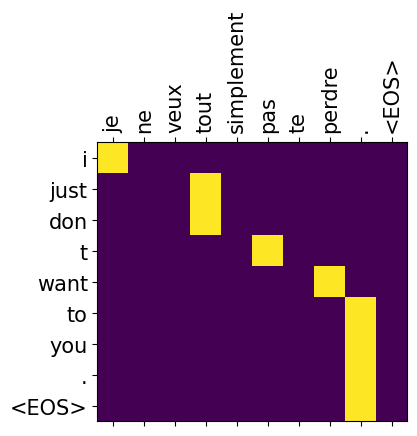

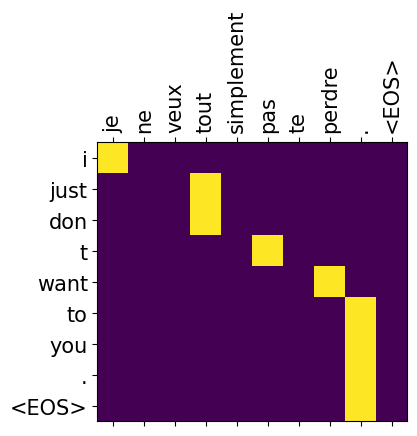

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def show_attention(sentence, translation, attention):
    sentence=sentence2wordlist(sentence)
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    im = ax.matshow(attention)
    ax.tick_params(labelsize=15)
    xticks = ['']+sentence
    yticks = ['']+translation
    ax.set_xticklabels(xticks, rotation=90)
    ax.set_yticklabels(yticks)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
show_attention(s,t,att[:,0:10])
show_attention(s,t,att[:,10:20])

In [ ]:
lines=[]
testpath='/content/drive/MyDrive/NLP/SEQ/eng-fra_test.txt'
with open((testpath) , encoding = 'utf-8') as f:
  for line in f:
    lines.append(line.rstrip())

def evaulate(encoder,decoder,lang1,lang2,num=1,inversed=1,maxlen=maxlen2):
  i=0;
  while i<num:
    idx=torch.randint(0,len(lines), (1,)).item()
    s1,s2=lines[idx].split('\t')
    if inversed:
      ss=s2
      s2=s1
      s1=ss
      translation=' '.join(str(x) for x in translate(s1,encoder,decoder,lang1=lang1,lang2=lang2,neat=1)[0])
      print (lang1+': '+s1)
      print('label: ',lang2+ ': '+s2)
      print ('translated: ', translation+'\n')
      i+=1

In [ ]:
evaulate(encoder, decoder, 'fra', 'eng', num=5, inversed=1)

fra: Il frotta une allumette.
label:  eng: He struck a match.
translated:  we re the .

fra: Elle était trop fatiguée pour travailler.
label:  eng: She was too tired to work.
translated:  i just tired of .

fra: Vous êtes trop bruyante.
label:  eng: You're too loud.
translated:  we re the of the of the of the of

fra: Allez vous laver les dents !
label:  eng: Go brush your teeth.
translated:  the .

fra: Peux-tu te le payer ?
label:  eng: Can you afford it?
translated:  do ?



#Hyper parameter tuning

In [ ]:
search_space = {
    'lr': [0.01, 0.001, 0.0001],
    'hidden_units': [128, 256, 512],
    'embd_dim': [128, 256, 512],
    'stack': [2,3,4,5,6,7],
    'dropout': [0.1, 0.12, 0.15,0.2,0.25,0.3],
    'TF_ratio': [0.5, 0.7, 0.9],
    'batch_size': [16, 32, 64]
}


In [ ]:
from torchtext.data.metrics import bleu_score
def bleu(encoder, decoder, lang1, lang2, size, num =1, inversed =1, maxlen= 12, maxiter =9999) :
  i=0
  labels=[]
  preds=[]
  while i<size:
    s1,s2=lines[i].split('\t')
    if inversed:
      ss=s2
      s2=s1
      s1=ss
      translation= translate(s1, encoder, decoder,lang1=lang1, lang2=lang2, neat=1)[0]
      labels.append([sentence2wordlist(s2) [:-1]])
      preds.append(translation)
      i+=1
    # if i%500==0: print(i)
    if i==maxiter or i ==size:
        break
  b=bleu_score (preds, labels, max_n=4)
  return b
bleu (encoder, decoder, 'fra' , 'eng', len(lines), inversed=1)

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


0.0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
  def __init__(self,hidden_units, embd_dim, stack, dropout=0,input_dim=numwords1):
    super(Encoder,self).__init__()
    self.input_dim=input_dim
    self.hidden_units=hidden_units
    self.embd_dim=embd_dim
    self.stack=stack
    self.embedding=nn.Embedding(input_dim,embd_dim)
    self.rnn=nn.GRU(embd_dim, hidden_units,stack,bidirectional=True,dropout=dropout,batch_first=True)
    self.dropout=nn.Dropout(dropout)
    self.hidden_srink=nn.Linear(hidden_units*2,hidden_units)

  def forward(self,input):
   # print(f"Input shape: {input.shape}") #(Input shape ) #(B,S)
    non_z=torch.count_nonzero(input,dim=1)  #(B)
    #print(f"Non-zero shape: {non_z.shape}")
    embd=self.dropout(self.embedding(input)) #(B,S,embd)
   # print(f"Embd shape : {embd.shape}")
    embd=nn.utils.rnn.pack_padded_sequence(embd,non_z.cpu(), batch_first=True) #(padded,embd)
   # print(f"After padding embd shape: {embd.data.shape}")
    output_packed, hidden = self.rnn(embd) #(outputpacked->(padded,hidden*2)) and hidden (2*Stack,B,hidden)
   # print(f"After passing with relu : output_packed shape {output_packed.data.shape} and  hidden shape {hidden.shape} ")
    output,re_zero_len=nn.utils.rnn.pad_packed_sequence(output_packed, batch_first=True , total_length=input.shape[1]) #(B,S,hidden*2) and #(B)
   # print(f"Using rnn pad packed sequence : output shape {output.shape} and re_zero_packed shape : {re_zero_len.shape}")
    hidden1=hidden[0:self.stack,:,:] #(stack,B,hidden)
    #print(f"hidden1 shape : {hidden1.shape}")
    hidden2=hidden[self.stack:,:,:] #(stack,B,hidden)
   # print(f"hidden2 shape : {hidden2.shape}")
    hidden=torch.cat((hidden1,hidden2),dim=2) #(stack,B,hiddden*2)
   # print(f"new concat shape of hidden :  {hidden.shape}")
    hidden=F.relu(self.hidden_srink(hidden)) # (stack,B,hidden)
   # print(f"hidden after srinking {hidden.shape}")
   # print(f"final output {output.shape}")
    return output,hidden,None


# decoder=Decoder(embed_dim,hidden_dim,2,rnn_input=512,output_dim=numwords1,Wsize=100,dropout=0.15,maxlen=maxlen2)

class Decoder(nn.Module):
  def __init__(self,embd_dim, hidden_unit,stack,dropout=0,rnn_input=512,output_dim=numwords1,maxlen=maxlen2,Wsize=256):
    super(Decoder,self).__init__()
    self.W=Wsize
    self.embd_dim=embd_dim
    self.hidden_unit=hidden_unit
    self.stack=stack
    self.rnn_input=rnn_input
    self.output_dim=output_dim
    self.maxlen=maxlen
    self.embedding=nn.Embedding(output_dim,embd_dim)
    self.dropout = nn.Dropout(dropout)
    self.FC_encoder=nn.Linear(hidden_dim*maxlen,maxlen * Wsize)
    self.FC_hidden=nn.Linear(hidden_dim,Wsize)
    self.FC_combo=nn.Linear(embd_dim+hidden_unit*2,rnn_input)
    self.rnn=nn.GRU(rnn_input,hidden_unit,stack,dropout=dropout,batch_first=True)
    self.FC_out=nn.Linear(hidden_unit*2 + embd_dim , output_dim)


  def forward(self,dec_input,hidden,enc_output,cell,mask=None):
    #Dec Input (B,1) hidden (stack,B,hidden) enc_output = (B,S,hidden*2)
    #print(f"dec_input : {dec_input.shape} and hidden {hidden.shape} and enc_output {enc_output.shape}")
    N=dec_input.shape[0] #(B)
    assert N==hidden.shape[1] #(B==B)
    L_src=enc_output.shape[1] #(S)
    assert L_src==self.maxlen #(S==S)
    emb=self.dropout(self.embedding(dec_input)) #(B,1,embd)
    #print(f"after passing emb layer : {emb.shape}")
    enc_out_reshape=torch.cat((enc_output[:,:,0:self.hidden_unit]  ,enc_output[:,:,0:self.hidden_unit]) , dim=1) #(B,S,hidden*2)->(B,2*S,hidden)
    #print(f"encoder output shape {enc_out_reshape.shape}")
    enc_out_flatten=enc_out_reshape.reshape(N,2,L_src*self.hidden_unit) #(B,2,S*hidden)
    #print(f"flattening encoder reshape : {enc_out_flatten.shape}")
    h_flat=hidden[-1].unsqueeze(1).view(N,1,self.hidden_unit) #(B,1,hidden)
    #print(f"flatting hidden shape {h_flat.shape}")
    key=F.relu(self.FC_encoder(enc_out_flatten)).reshape(N,2*L_src,self.W) #(B,2,S*hidden)->(B,2*S,W)
    #print(f"key shape : {key.shape}")
    query=F.relu(self.FC_hidden(h_flat)).reshape(1,N,self.W) #(B,1,hidden)->(1,B,W)
    #print(f"query shape: {query.shape}")
    attention=torch.einsum("nmw,onw->onm" , [key,query]) #(B,2*S,W)@(1,B,W)->(1,B,2*S)
    #print(f"attention shape : {attention.shape}")
    att1,att2=attention[0,:,0:L_src] , attention[0,:,L_src:] #(B,S)
    #print(f"att1 shape : {att1.shape} and att2 shape : {att2.shape}")
    if mask is not None:
      att1=att1.masked_fill(mask==0,-1e-20)
      att2=att2.masked_fill(mask==0,-1e-20)
    attention=torch.cat((F.softmax(att1,dim=1) , F.softmax(att2,dim=1)), dim=1).unsqueeze(0) #(1,B,2*S)
    #print(f"attention after masked shape : {attention.shape}")
    context=torch.einsum("onm,nmh->noh",[attention,enc_out_reshape])#(1,B,2*S)@(B,2*S,hidden)->(B,1,hidden)
    #print(f"context shape: {context.shape}")
    combo=torch.cat((emb,hidden[-1].unsqueeze(1),context) , dim=2) #(B,1,embd)+(B,1,hidden)+(B,1,hidden)->(B,1,2*hidden+embd)
    #print(f"combo shape : {combo.shape}")
    combo=F.relu(self.FC_combo(combo)) #(B,1,rnn_dim)
    #print(f"combo after linear trans: {combo.shape}")
    dec_output,new_hidden=self.rnn(combo,hidden) #(B,1,hidden) (stack,B,hidden)
    #print(f"decoder output : {dec_output.shape} and hidden state output : {new_hidden.shape}")
    outcombo=torch.cat((dec_output.squeeze(1) , context.squeeze(1),emb.squeeze(1)) , dim=1) #(B,hidden)+(B,hidden)+(B,embd)->(B,2*hidden+embd)
    #print(f"outcombo shape : {outcombo.shape}")
    dec_output=F.log_softmax(self.FC_out(outcombo),dim=1).view(N,self.output_dim) #(B,output_dim)
    #print(f"decoutput after trans+softmax func: {dec_output.shape}")
    return dec_output, new_hidden,attention.squeeze(0),None


def train(encoder, decoder,n_epochs, train_lang1, train_lang2,val_lang1=None, val_lang2=None, \
           lr=0.01,batch_size=32,sortInBatch=1,TF_ratio=0.5,maxlen=maxlen2, chptname=None, comment=''):
    encoder_optimizer=optim.SGD(encoder.parameters(),lr=lr)
    decoder_optimizer=optim.SGD(decoder.parameters(),lr=lr)
    criterion=nn.NLLLoss(ignore_index=0,reduction='sum')
    N=batch_size
    chpt_loss=999
    iters=train_lang1.shape[0]//N
    if not train_lang1.shape[0]%N==0:
      iters+=1
    epochcount=0
    for b in range(n_epochs) :
      epochcount+=1
      num_trained=0
      epoch_num_trained=0
      epoch_loss=0
      iteridxs=torch.randperm(iters)
      for iter in range(iters):
        source=train_lang1[iteridxs[iter]*N:(iteridxs[iter]+1)*N].to(device)
        target=train_lang2[iteridxs[iter]*N:(iteridxs[iter]+1)*N].to(device)
        if sortInBatch:
          lens=torch.count_nonzero(source, dim=1)
          new_indices=torch.argsort(lens,descending=True)
          source=source[new_indices, :]
          target=target[new_indices, :]
        loss,actual_batch_size=train_batch(source,target,encoder,decoder,encoder_optimizer, decoder_optimizer,
                                                                            criterion, TF_ratio=TF_ratio, maxlen=maxlen)
        num_trained+=actual_batch_size
        epoch_num_trained+=actual_batch_size
        epoch_loss+=loss
      print(b+1, 'epoch train loss: ' , epoch_loss/epoch_num_trained)
      val_loss=999

      if val_lang1 is not None and val_lang2  is not None:
        val_loss=validate(encoder,decoder,val_lang1,val_lang2, batch_size=batch_size,maxlen=maxlen)
        print('epoch validation loss: ',val_loss)
      if chptname is not None:
        if val_loss<chpt_loss:
          torch.save ({
          'enc_state_dict': encoder.state_dict(),
          'dec_state_dict': decoder.state_dict(),
          'train loss': epoch_loss/epoch_num_trained,
          'val_loss': val_loss,
          'batch size':batch_size,
          'epoch' :b,
          'comment': comment,
          },'/content/drive/MyDrive/NLP/SEQ'+chptname+str(b)+"stack=6")

          chpt_loss=val_loss

def validate(encoder, decoder, train_lang1, train_lang2,batch_size=32,sortInBatch=1,maxlen=maxlen2):
    N=batch_size
    n_iters=train_lang1.shape[0]//N
    if not train_lang1.shape[0]%N==0:
      n_iters+=1
    epoch_num_trained=0
    epoch_loss=0
    criterion = nn.NLLLoss(ignore_index =0, reduction='sum')
    for iter in range(1, n_iters + 1):
      input = train_lang1[(iter-1)*N: (iter)*N].to(device)
      target =train_lang2[(iter-1)*N: (iter)*N].to(device)
      if sortInBatch:
        lens=torch.count_nonzero(input, dim=1)
        new_indices=torch.argsort(lens,descending=True)
        input=input[new_indices, :]
        target=target[new_indices,:]
      loss,actual_batch_size = validate_batch(input, target, encoder,decoder, criterion, maxlen=maxlen)
      epoch_num_trained+=actual_batch_size
      epoch_loss+=loss
    return epoch_loss/epoch_num_trained

def validate_batch(input, target, encoder, decoder, criterion, maxlen= maxlen2):
    encoder.eval()
    decoder.eval()
    loss=0
    with torch.no_grad():
      input_length = input.size(1)
      assert input_length==maxlen
      target_length = target.size(1)
      N=input.size(0)
      assert N ==target.size(0)
      encoder_outputs,hidden,cell=encoder(input)
      mask = (input!=0)
      decoder_input = torch.ones((N,1), device=device).int()
      dec_ended=torch.zeros(N, device=device).int()
      for di in range(target_length):
        if torch.sum(target[:,di])==0:
          break
        decoder_output,hidden,_,cell = decoder(decoder_input,hidden,encoder_outputs,cell,mask)
        topv,topi = decoder_output.topk(1)
        decoder_input =topi.detach()
        loss += criterion(decoder_output, target[:,di].long())/N
        decoder_input = target[:,di].unsqueeze(1)
      return loss,N

def train_batch(input,target,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,maxlen=maxlen2,TF_ratio=0.5):

  encoder.train()
  decoder.train()
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()
  input_length=input.shape[1]
  assert input_length==maxlen
  target_length=target.shape[1]
  N=input.shape[0] #(B,S)
  assert N==target.shape[0]
  loss=0
  encoder_output,hidden,cell=encoder(input)
  mask=(input!=0)
  decoder_input=torch.ones((N,1), device=device).int()
  TF=True if random.random()<TF_ratio else False

  loopcount=0;
  if TF:
    for i in range(target_length):
      if torch.sum(target[:,i])==0:
        break
      decoder_output,hidden,_,cell=decoder(decoder_input,hidden,encoder_output,cell,mask)
      loss+=criterion(decoder_output,target[:,i].long())/N
      decoder_input=target[:,i].unsqueeze(1)
      loopcount+=1
  else:
    for i in range(target_length):
      if torch.sum(target[:,i])==0:
        break
      decoder_output,hidden,_,cell=decoder(decoder_input,hidden,encoder_output,cell,mask)
      val,idx=decoder_output.topk(1)
      decoder_input= idx.detach()
      #print (decoder_output.shape, target [:,11. long() -shape)
      loss+=criterion(decoder_output,target[:,i].long())/N
      loopcount+=1
  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()
  return loss.item(),N
